# Distributed Optimization with the Alternating Direction Method of Multipliers

In this lecture we will see the how the ADMM algorithm can be used for distributed optimization. Using the notatation from the course slides, we aim to solve the following optimization problem:

![](ADMM_problem.png)


The algorithm is described by the following iteration:

![](ADMM_algorithm.png)

where the first N updates can be done in parallel.


__Structure of this session:__

   * ADMM with 1 split (sequential algorithm).
   * ADMM with 2 splits or more.
   * We will see one application of the lasso: tomography reconstruction. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## ADMM for the Lasso with a single machine

We will now use ADMM to solve a nonsmooth optimization problem.


The Lasso is staistical model that has found many applications in machine learning, signal processing, biomedical imaging and genetics, to name a few. Given a regression dataset $X \in \mathbb{R}^{n \times p}, y \in \mathbb{R}^n$, the Lasso is determined as the solution to the optimization problem

$$\text{argmin}_{\theta} \frac{1}{2n}\|X \theta - y\|^2 + \lambda \|\theta\|_1 \quad,$$
where $\lambda \geq 0$ is a regularization parameter. The Lasso model is so useful because, given enough regularization, it gives solutions which are *sparse*, i.e., with many zero coefficients.

### ADMM formulation of the Lasso

We can reformulate the Lasso problem in the following equivalent form
$$
\begin{aligned}
&\text{argmin}_{\theta} \frac{1}{2n}\|X \theta - y\|^2 + \lambda \|\rho\|_1 \quad,\\
&\text{ subject to }~ \theta=\rho
\end{aligned}
$$

Now that we have written it in ADMM-friendly fashion, we can use the the above algorithm with $N=1$. This gives the following iteration:
$$
\begin{aligned}
&\theta^{t+1} = \text{argmin}_{\theta} \frac{1}{2n}\|X \theta - y\|^2 + \frac{\tau}{2}\|\theta - \rho^t + u^t\|^2 \\
&\rho^{t+1} = \text{argmin}_{\theta} \lambda \|\theta\|_1 + \frac{\tau}{2} \|\theta - \theta^{t+1} - u^t\|^2\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$

It turns that for this particular problem many of the steps have a closed form solution. Using this we have the following closed form updates:
$$
\begin{aligned}
&\theta^{t+1} = (X^T X / n + \tau I)^{-1}(X^T y / n + \tau (\rho^t - u^t)) \\
&\rho^{t+1} = (\theta^{t+1} + u^t - \frac{\tau}{\lambda})_+ - (-\frac{\tau}{\lambda} - \theta^{t+1} - u^t)_+\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$

where $(\cdot)_+$ denote the positive part, i.e., $(x)_+ := \text{max}(x, 0)$.

### Simulated Data

In [2]:
n_samples, n_features = 100, 100
sigma = 0.1 # Noise level

# Sparse coefficients: keep only 10 non-zero coefficients
theta_star = np.random.randn(n_features)
ind = np.arange(n_features)
np.random.shuffle(ind)
theta_star[ind[:-10]] = 0.

# Simulate the data
X = np.random.randn(n_samples, n_features)
y = X.dot(theta_star) + sigma*np.random.randn(n_samples)

### Algorithm

In [3]:
def objective_lasso(theta, X, y, lam):
    '''
        Return the value of the lasso for data `X`,`y`, parameter `theta` and regularization strength `lam`.
    '''
    n_samples = X.shape[0]
    loss = (0.5 / n_samples) * np.linalg.norm(X.dot(theta) - y)**2
    return loss + lam * np.sum(np.abs(theta))

In [4]:
def lasso_ADMM(X, y, lam, max_iter=100, tau=1.):
    '''
        Run the ADMM iterations for the Lasso.
    '''
    n_samples, n_features = X.shape
    rho = np.zeros(n_features)
    u = np.zeros(n_features)
    
    objective_history = []

    XtX_inv = np.linalg.pinv(X.T.dot(X) / n_samples + tau * np.eye(n_features))
    for _ in range(max_iter):
        theta = XtX_inv.dot( ((1/n_samples)*X.T.dot(y) + tau * (rho - u)) )
        rho = np.fmax(theta + u - lam/tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        u = u + theta - rho
        objective_history.append(objective_lasso(theta, X, y, lam))

    return theta, objective_history

In [5]:
lam = np.sqrt(2*sigma*np.log(n_features)/n_samples)
theta_hat, objective_history = lasso_ADMM(X, y, lam)

Let us plot the convergence:

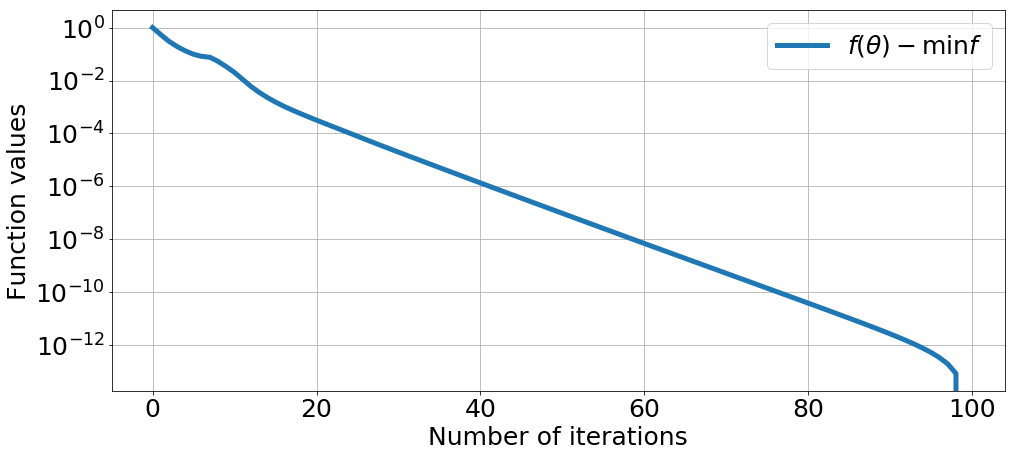

In [6]:
plt.figure(figsize=(16,7))
plt.semilogy(objective_history-np.min(objective_history), lw=5, label='$f(\\theta) - \min{f}$')
plt.ylabel('Function values', fontsize=25)
plt.xlabel('Number of iterations', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()

The Lasso retrieve the real non-zero coefficients, provided $\lambda$ is well chosen:

In [7]:
print("Detected non-zero coefficients: ", np.where(np.abs(theta_hat)>1e-10)[0])
print("True non-zero coefficients:     ", np.where(np.abs(theta_star)>0)[0])

Detected non-zero coefficients:  [14 36 66 70 77 80 82 83 98]
True non-zero coefficients:      [ 0 14 36 66 70 77 80 82 83 98]


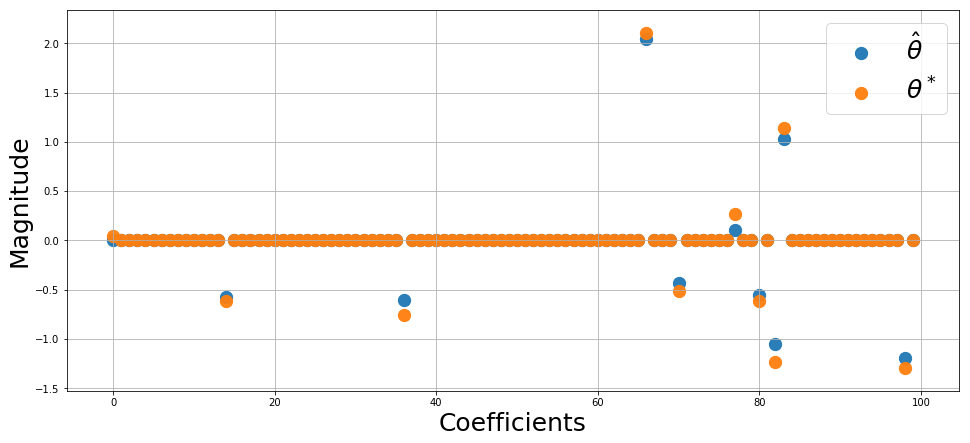

In [8]:
plt.figure(figsize=(16,7))
plt.scatter(range(n_features), theta_hat, alpha=0.95, s=150, label='$\hat\\theta$')
plt.scatter(range(n_features), theta_star, alpha=0.95, s=150, label='$\\theta^*$')
plt.ylabel('Magnitude', fontsize=25)
plt.xlabel('Coefficients', fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()

## ADMM for the Lasso with two machines

We will now use ADMM to actually do some distributed computations. For this we can split the first subproblem into two ($N=2$) and using the ADMM algorithm specified at the beginning.


In [9]:
def lasso_ADMM_2(X, y, lam, max_iter=100, tau=1.):

    # Split the dataset
    X_1, X_2 = np.array_split(X, 2)
    y_1, y_2 = np.array_split(y, 2)
    
    # Initialization
    n_samples, n_features = X.shape
    rho = np.zeros(n_features)
    u_1 = np.zeros(n_features)
    u_2 = np.zeros(n_features)
    
    objective_history = []
    
    XtX_1_inv = np.linalg.pinv(X_1.T.dot(X_1) / n_samples + tau * np.eye(n_features))
    XtX_2_inv = np.linalg.pinv(X_2.T.dot(X_2) / n_samples + tau * np.eye(n_features))

    for _ in range(max_iter):
        theta_1 = XtX_1_inv.dot(X_1.T.dot(y_1) / n_samples + tau * (rho - u_1))
        theta_2 = XtX_2_inv.dot(X_2.T.dot(y_2) / n_samples + tau * (rho - u_2))
        u = (u_1 + u_2) / 2.
        theta = (theta_1 + theta_2) / 2.
        rho = np.fmax(theta + u - lam/tau, 0) - np.fmax(-tau/lam - theta - u, 0)
        u_1 = u_1 + theta_1 - rho
        u_2 = u_2 + theta_2 - rho
        objective_history.append(objective_lasso(theta_1, X, y, lam))

    return theta, objective_history

In [10]:
lam = np.sqrt(2*sigma*np.log(n_features)/n_samples)
theta, objective_history = lasso_ADMM_2(X, y, lam)

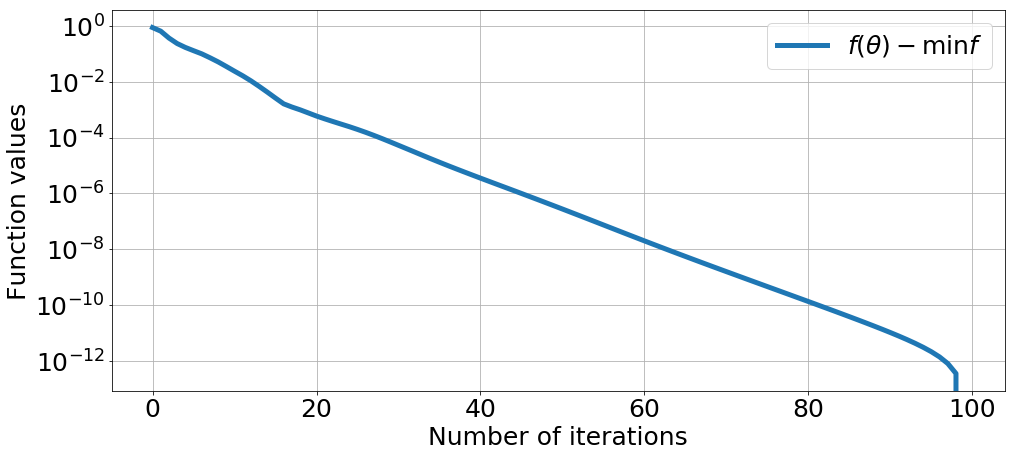

In [11]:
plt.figure(figsize=(16,7))
plt.semilogy(objective_history-np.min(objective_history), lw=5, label='$f(\\theta) - \min{f}$')
plt.ylabel('Function values', fontsize=25)
plt.xlabel('Number of iterations', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()

The Lasso retrieve the real non-zero coefficients, provided $\lambda$ is well chosen:

In [12]:
print("Detected non-zero coefficients: ", np.where(np.abs(theta_hat)>1e-10)[0])
print("True non-zero coefficients:     ", np.where(np.abs(theta_star)>0)[0])

Detected non-zero coefficients:  [14 36 66 70 77 80 82 83 98]
True non-zero coefficients:      [ 0 14 36 66 70 77 80 82 83 98]


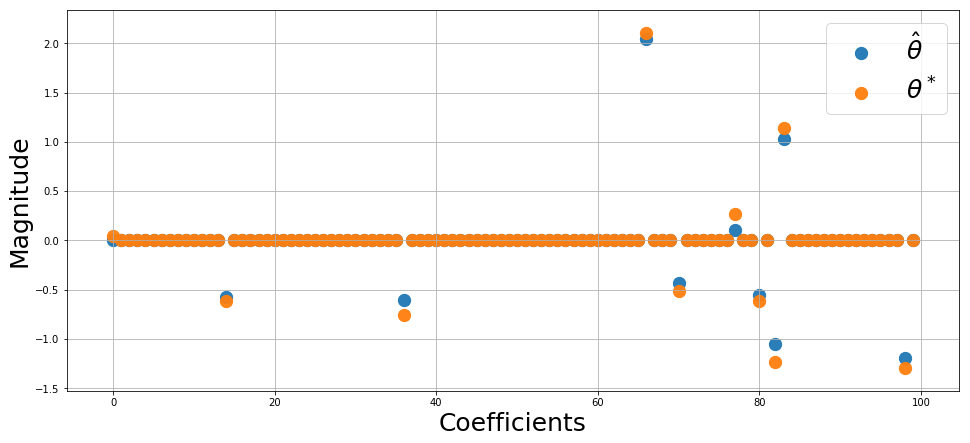

In [13]:
plt.figure(figsize=(16,7))
plt.scatter(range(n_features), theta_hat, alpha=0.95, s=150, label='$\hat\\theta$')
plt.scatter(range(n_features), theta_star, alpha=0.95, s=150, label='$\\theta^*$')
plt.ylabel('Magnitude', fontsize=25)
plt.xlabel('Coefficients', fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()

## Compressive sensing application: tomography reconstruction with the Lasso


This example shows the reconstruction of an image from a set of parallel projections, acquired along different angles. Such a dataset is acquired in computed tomography (CT).

Without any prior information on the sample, the number of projections required to reconstruct the image is of the order of the linear size l of the image (in pixels). For simplicity we consider here a sparse image, where only pixels on the boundary of objects have a non-zero value. Such data could correspond for example to a cellular material. Note however that most images are sparse in a different basis, such as the Haar wavelets. Only l/2 projections are acquired, therefore it is necessary to use prior information available on the sample (its sparsity): this is an example of compressive sensing.

The tomography projection operation is a linear transformation. In addition to the data-fidelity term corresponding to a linear regression, we penalize the L1 norm of the image to account for its sparsity. **The resulting optimization problem is called the Lasso**.


The reconstruction with L1 penalization should give a result with zero error (all pixels are successfully labeled with 0 or 1), even if noise was added to the projections. In comparison, an L2 penalization (sklearn.linear_model.Ridge) produces a large number of labeling errors for the pixels. Important artifacts are observed on the reconstructed image, contrary to the L1 penalization. Note in particular the circular artifact separating the pixels in the corners, that have contributed to fewer projections than the central disk.

In [14]:
from __future__ import division

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [15]:
# Generate synthetic images, and projections
l = 25
proj_operator = build_projection_operator(l, l // 2)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

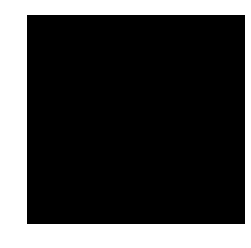

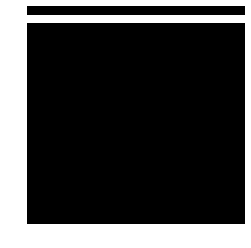

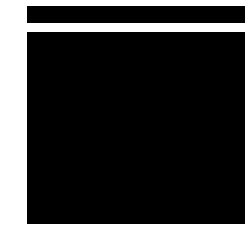

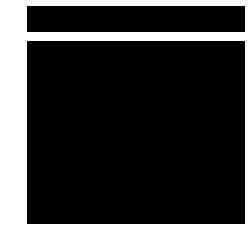

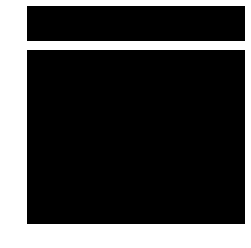

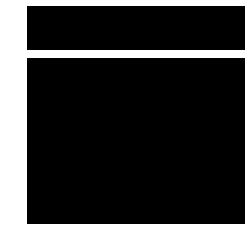

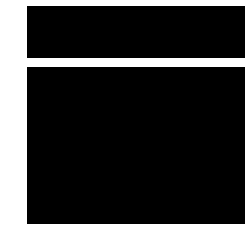

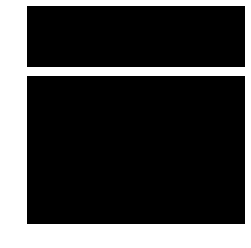

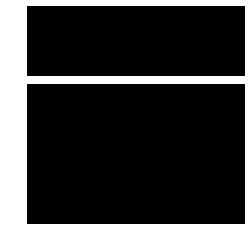

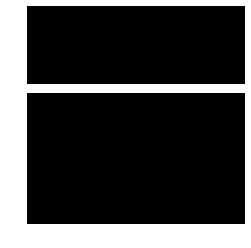

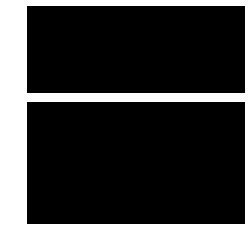

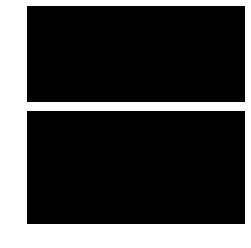

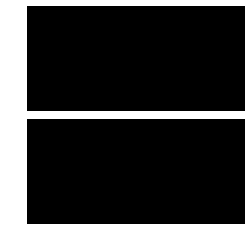

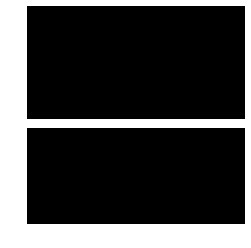

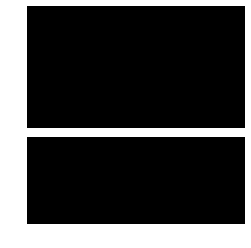

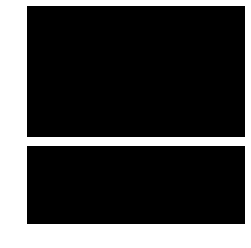

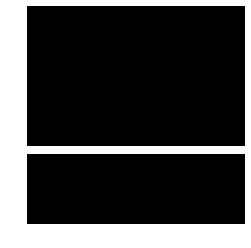

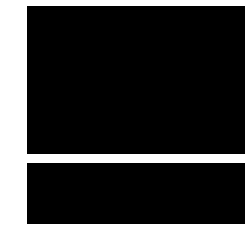

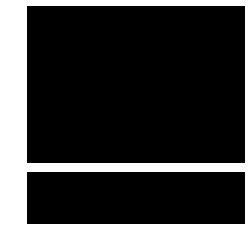

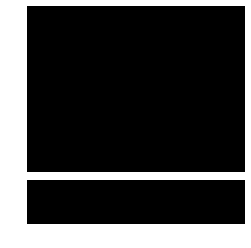

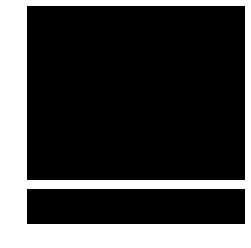

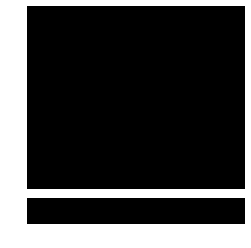

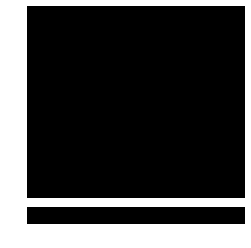

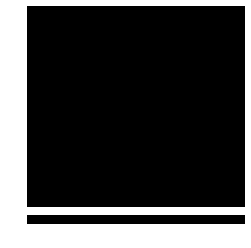

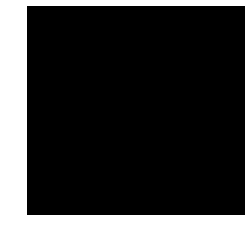

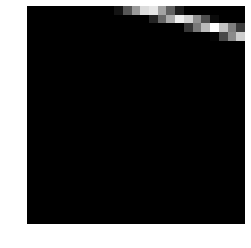

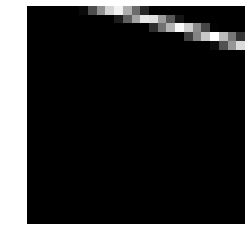

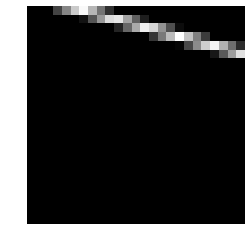

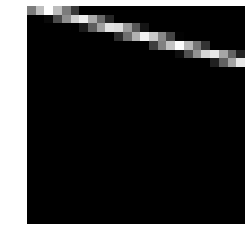

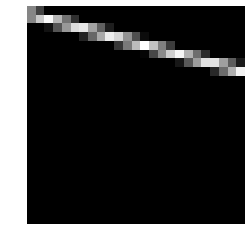

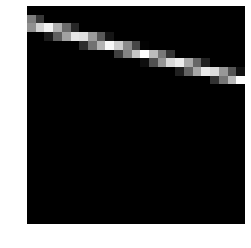

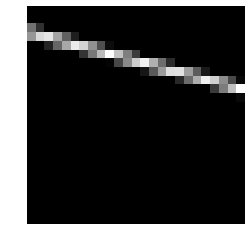

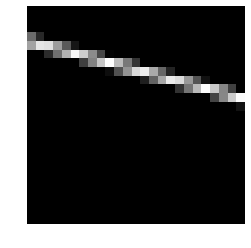

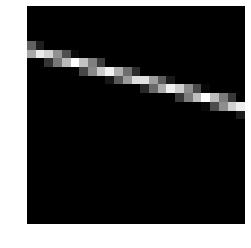

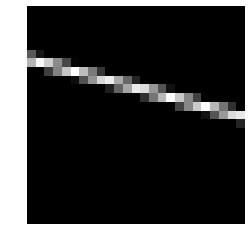

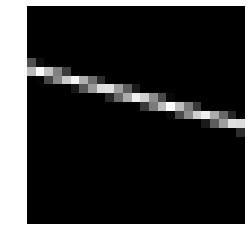

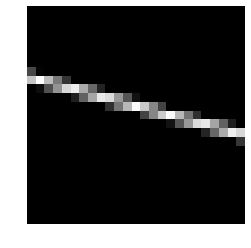

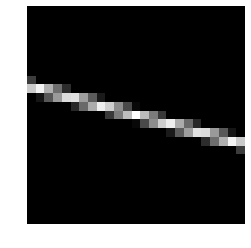

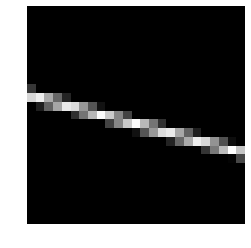

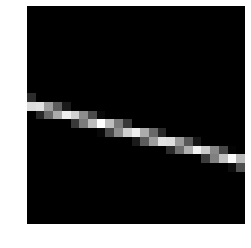

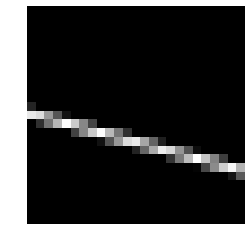

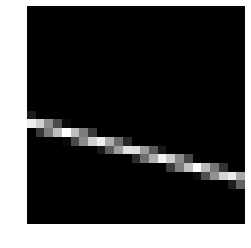

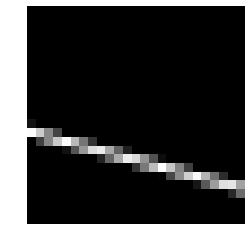

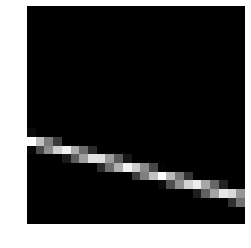

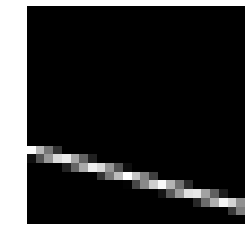

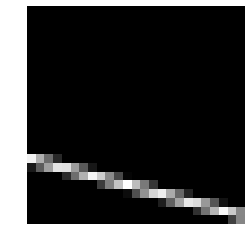

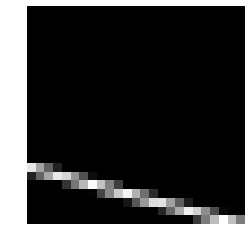

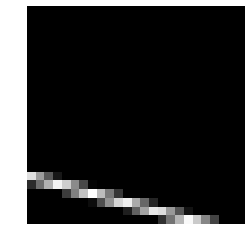

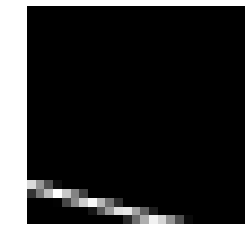

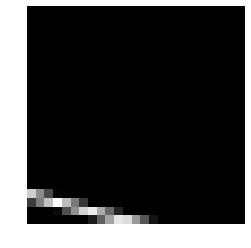

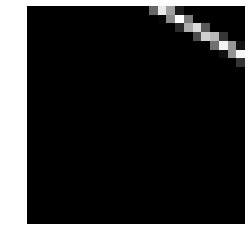

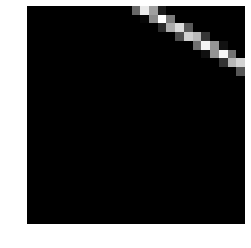

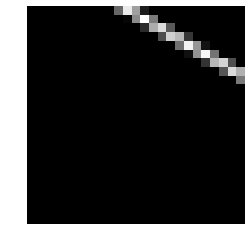

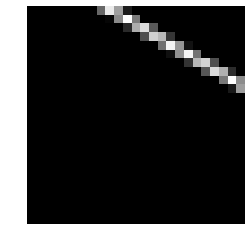

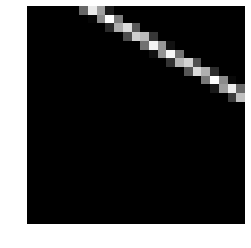

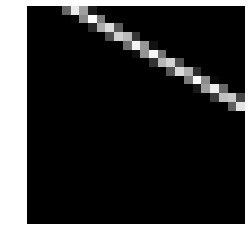

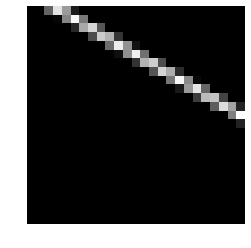

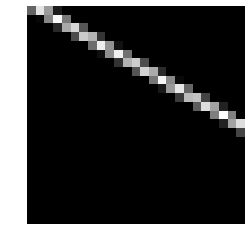

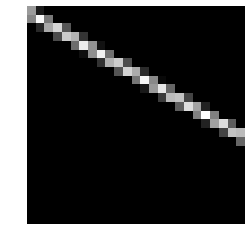

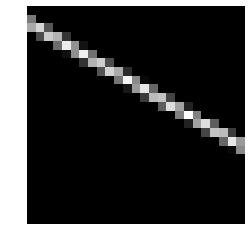

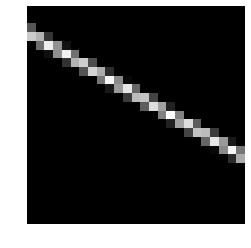

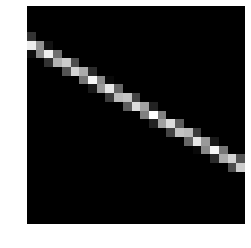

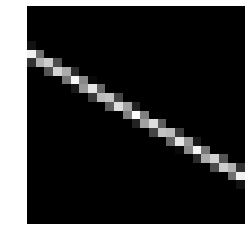

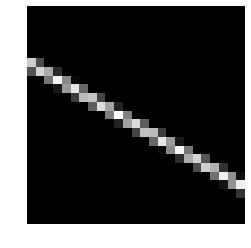

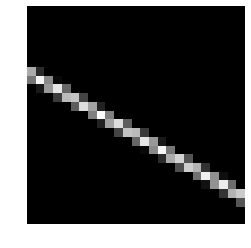

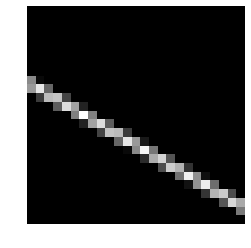

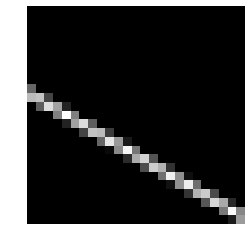

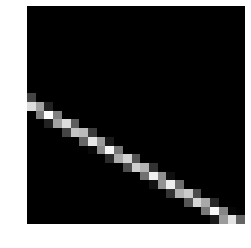

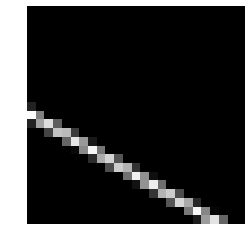

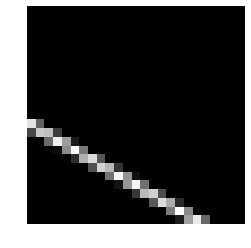

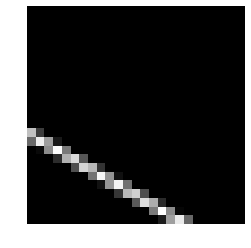

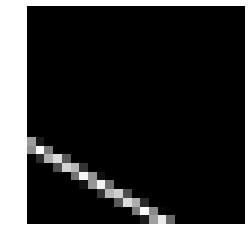

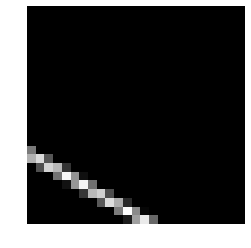

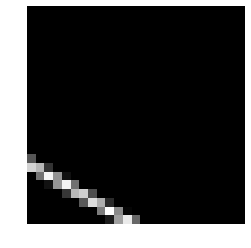

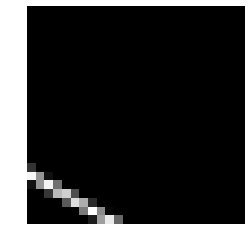

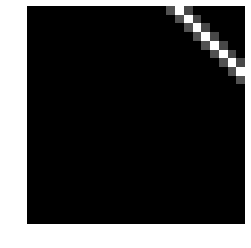

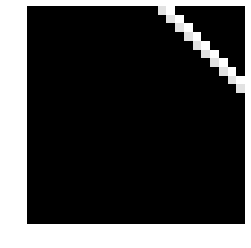

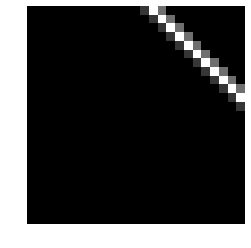

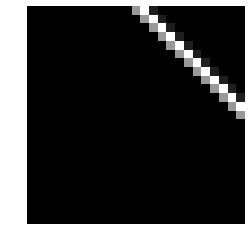

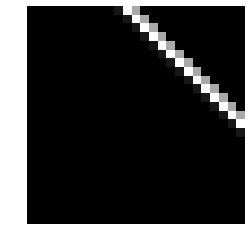

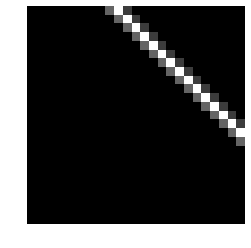

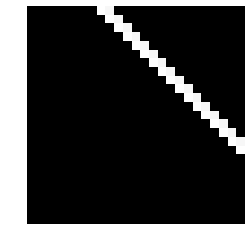

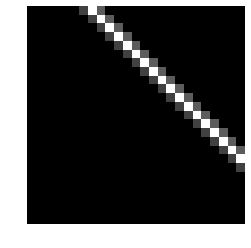

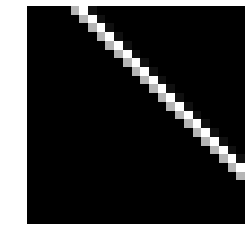

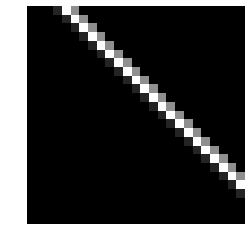

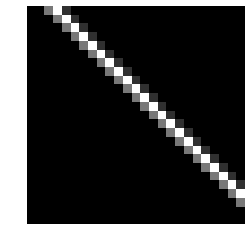

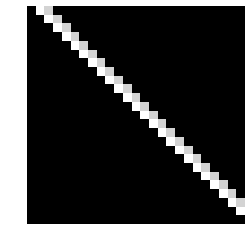

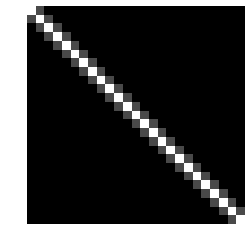

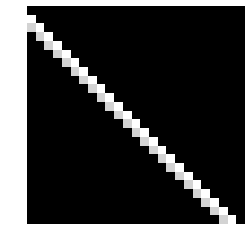

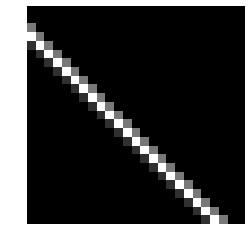

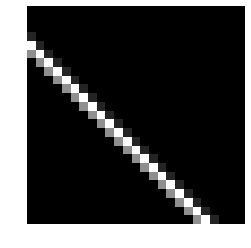

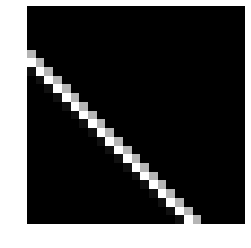

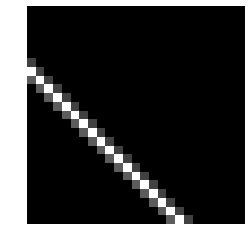

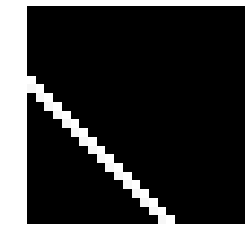

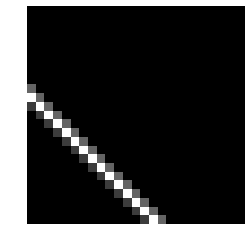

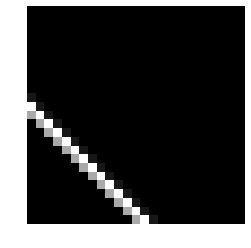

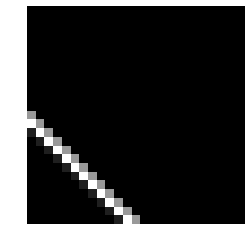

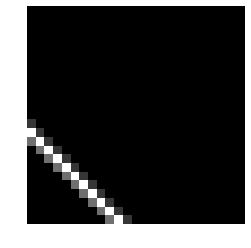

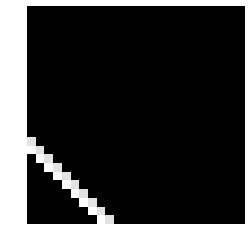

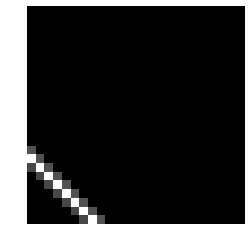

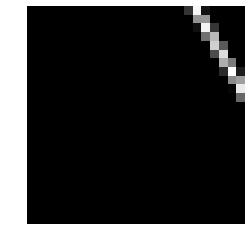

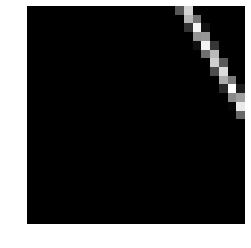

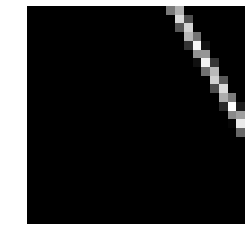

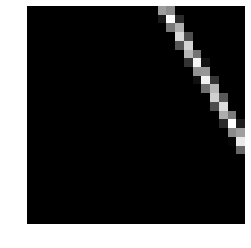

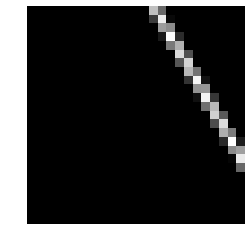

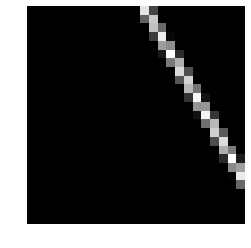

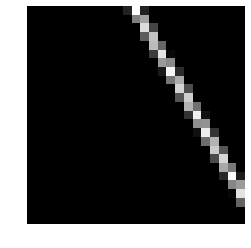

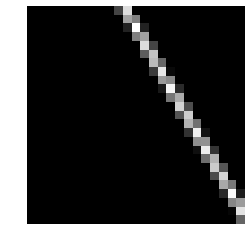

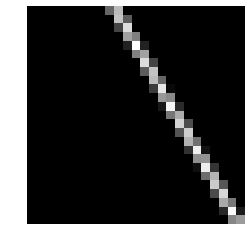

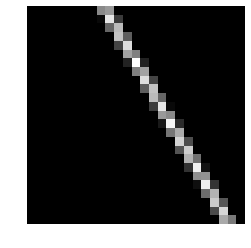

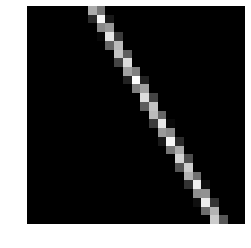

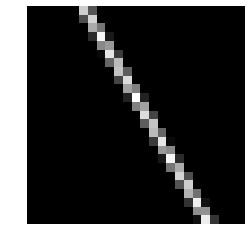

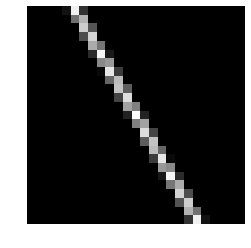

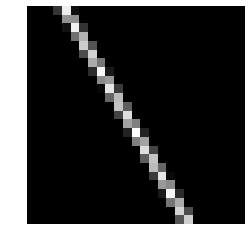

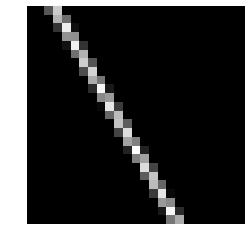

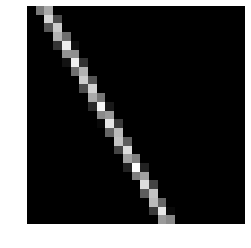

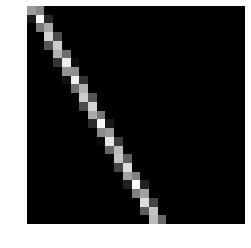

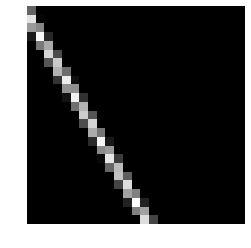

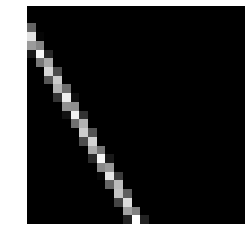

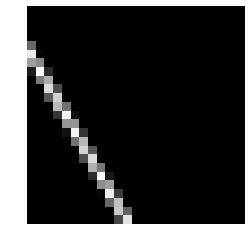

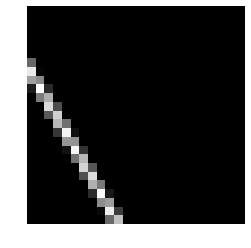

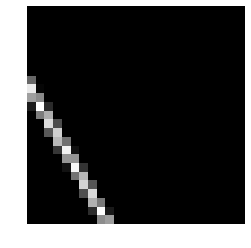

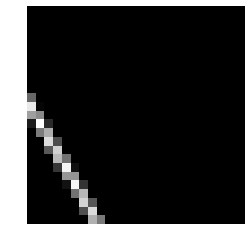

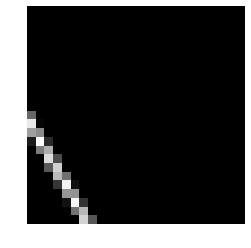

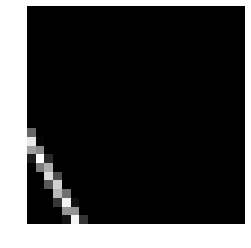

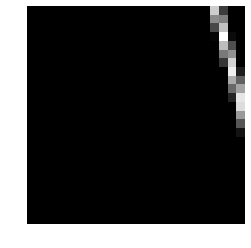

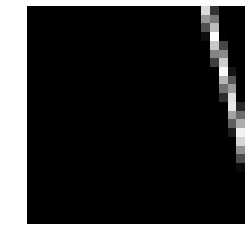

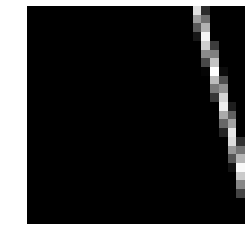

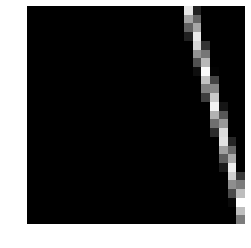

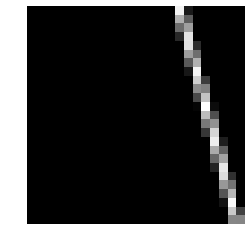

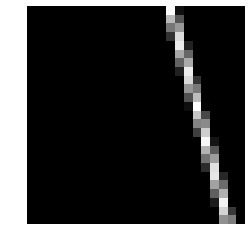

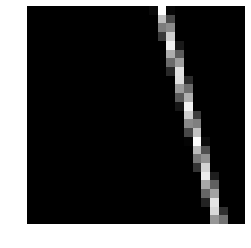

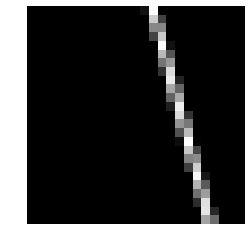

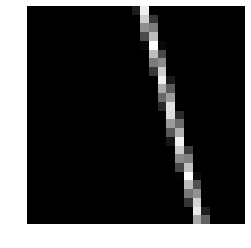

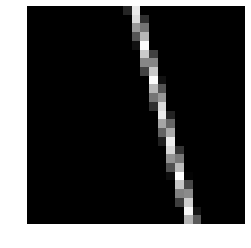

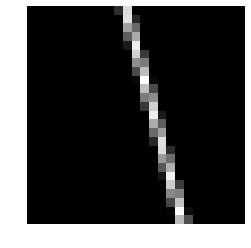

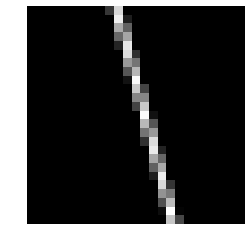

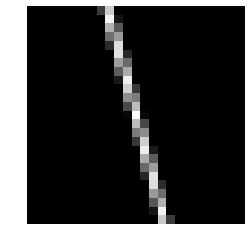

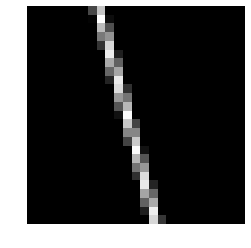

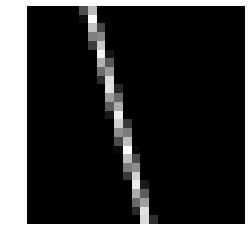

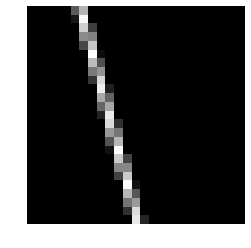

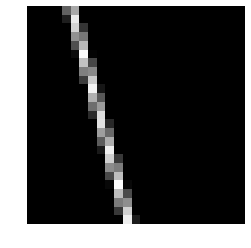

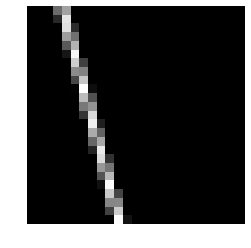

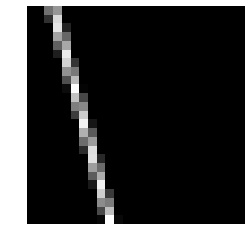

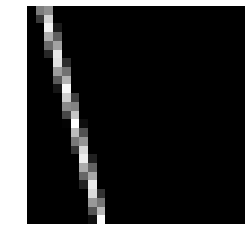

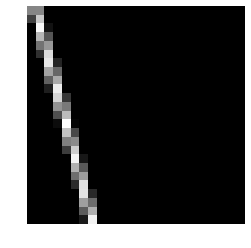

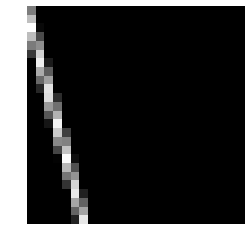

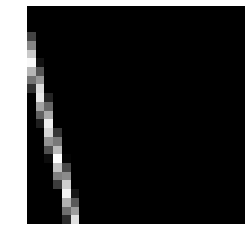

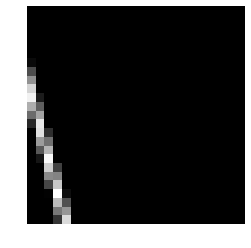

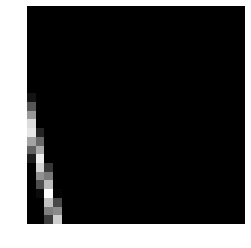

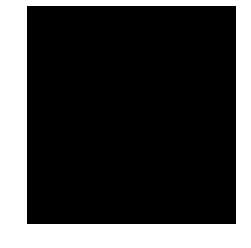

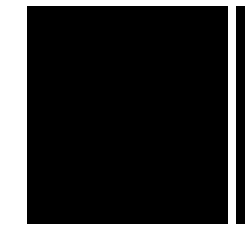

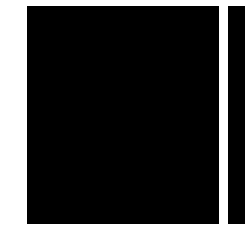

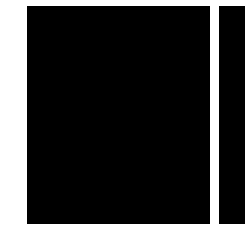

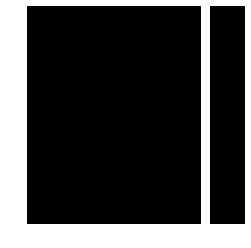

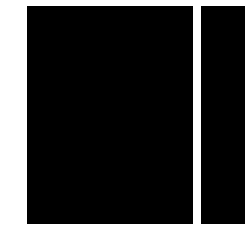

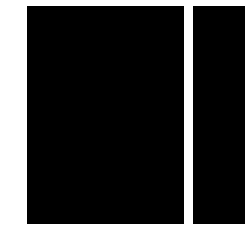

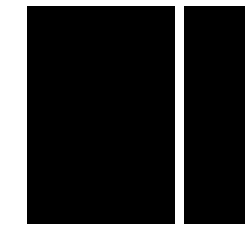

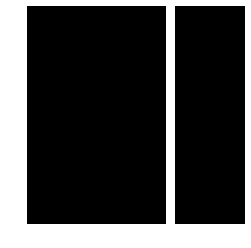

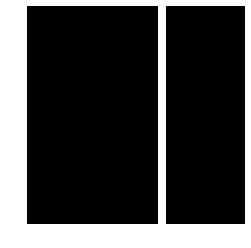

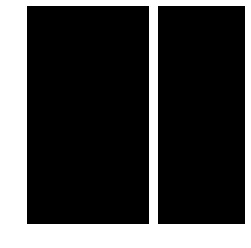

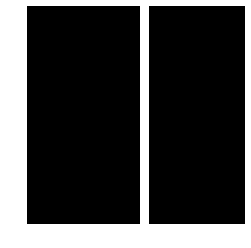

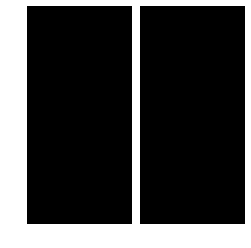

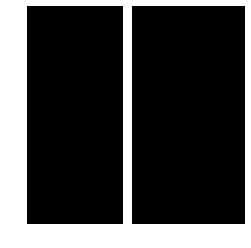

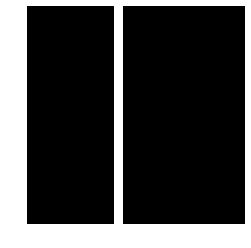

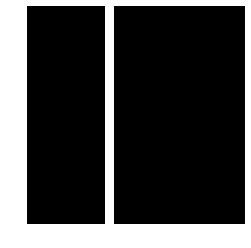

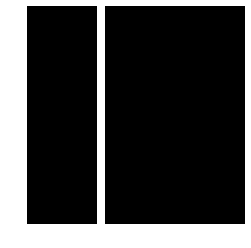

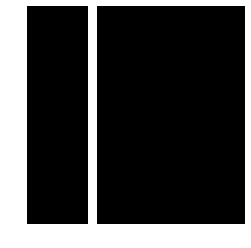

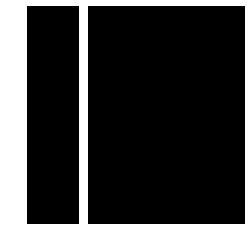

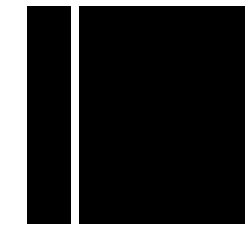

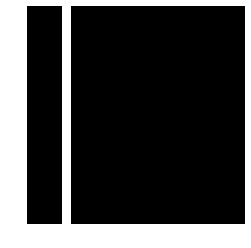

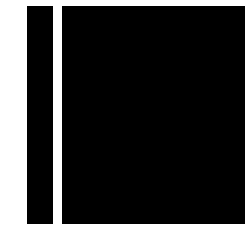

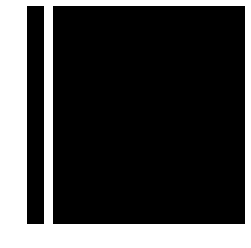

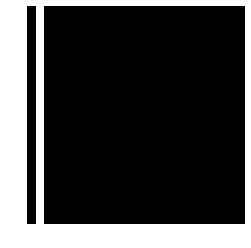

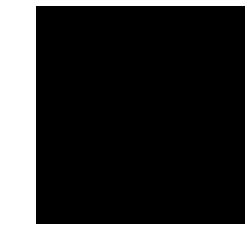

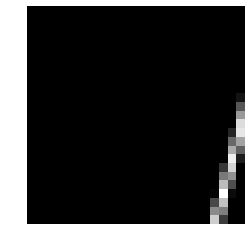

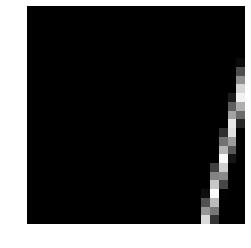

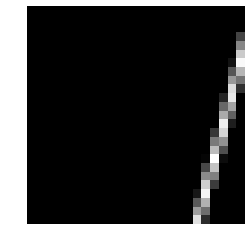

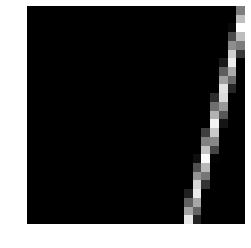

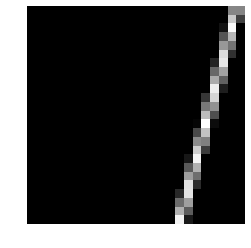

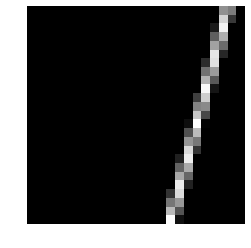

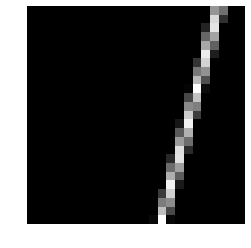

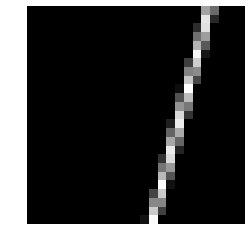

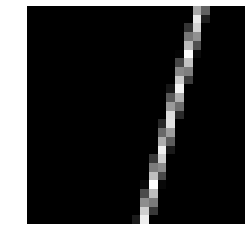

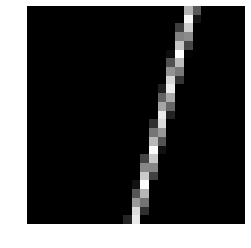

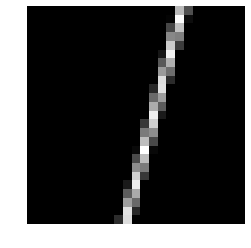

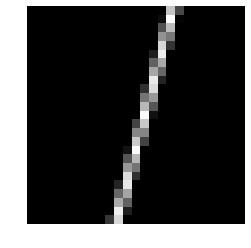

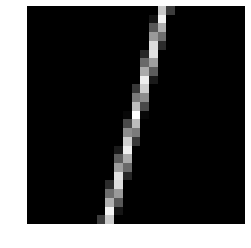

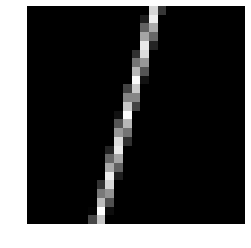

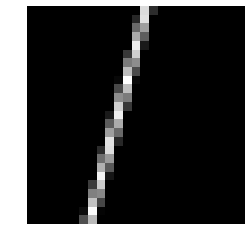

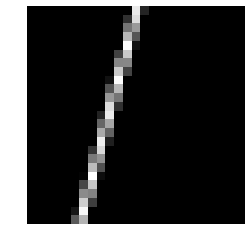

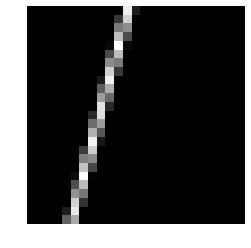

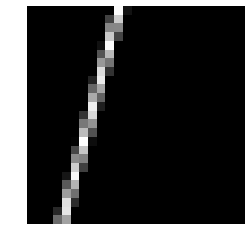

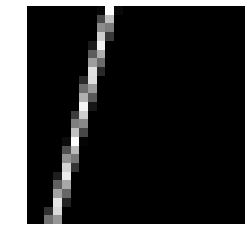

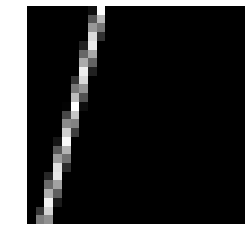

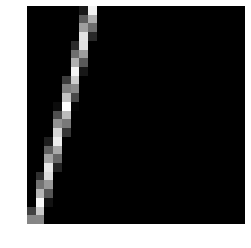

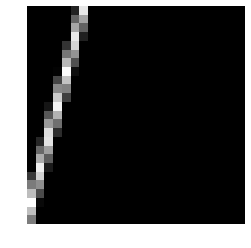

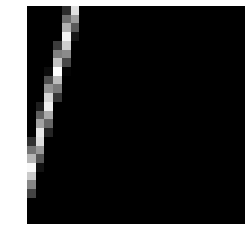

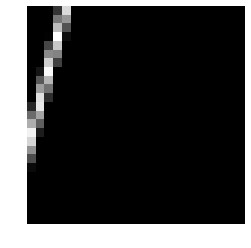

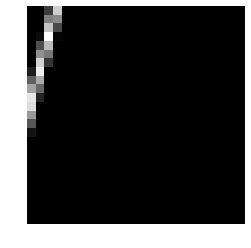

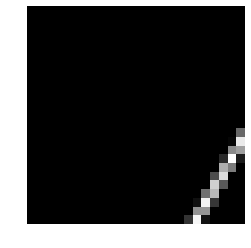

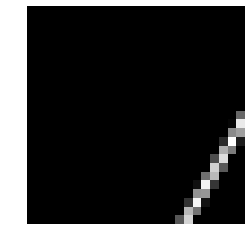

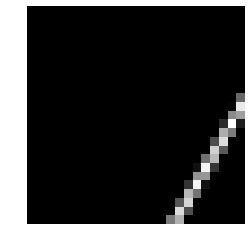

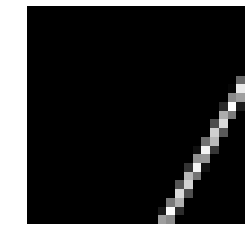

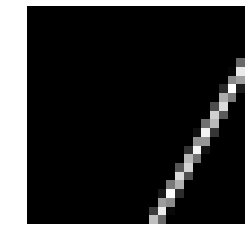

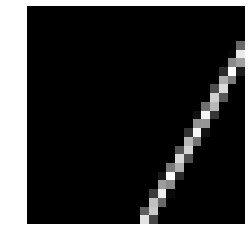

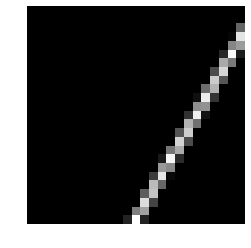

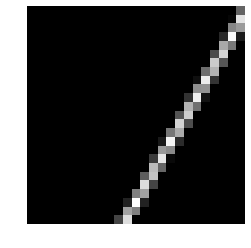

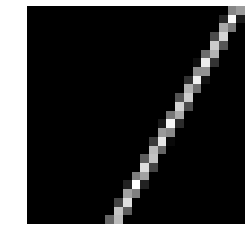

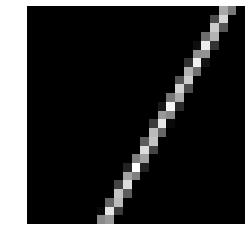

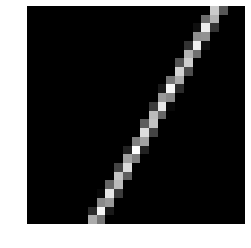

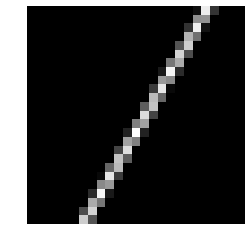

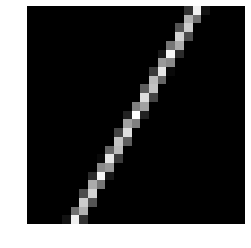

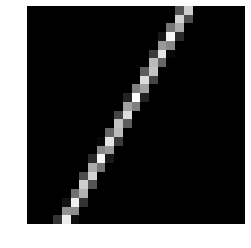

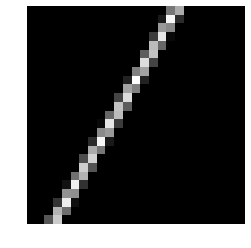

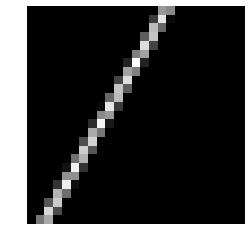

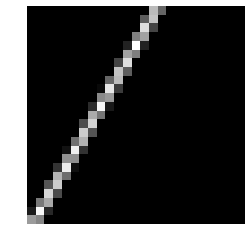

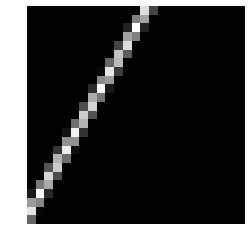

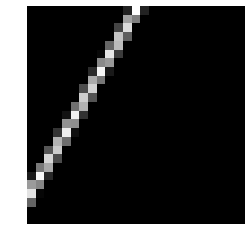

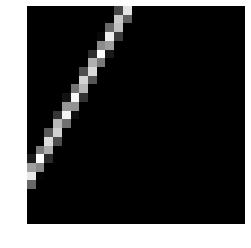

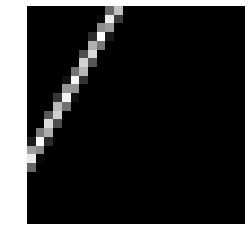

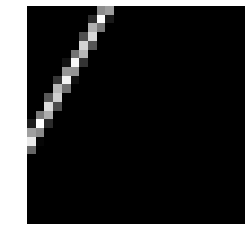

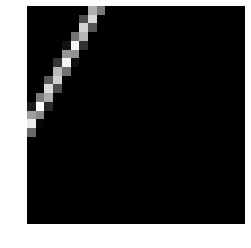

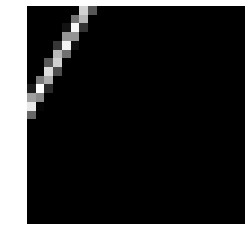

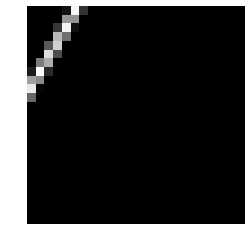

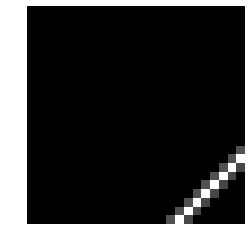

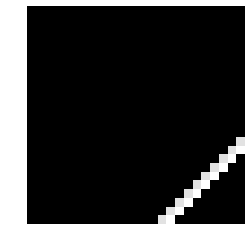

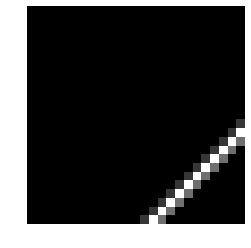

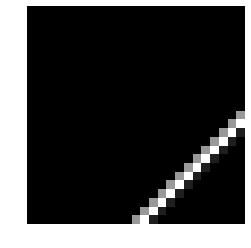

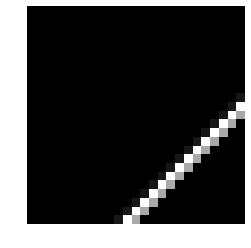

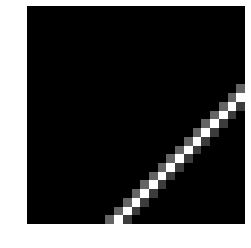

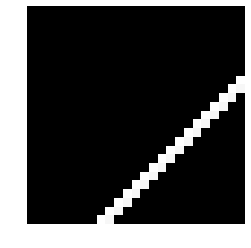

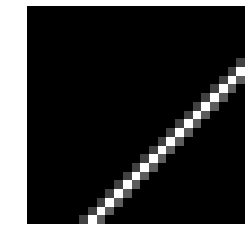

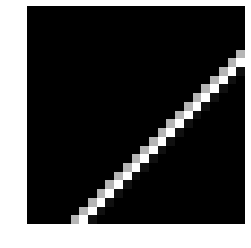

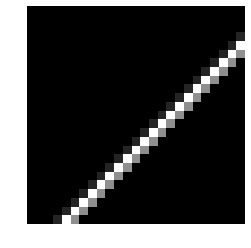

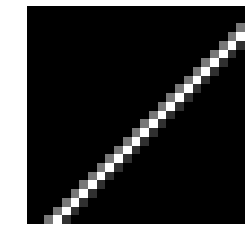

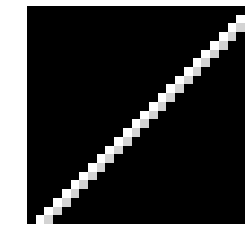

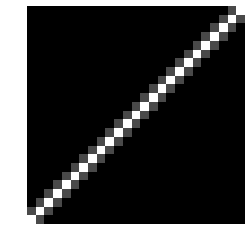

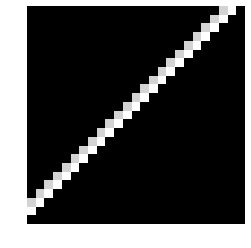

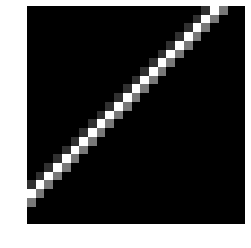

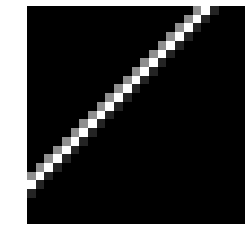

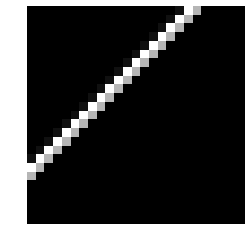

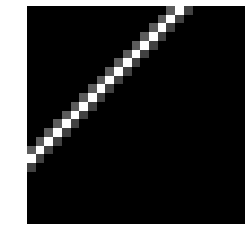

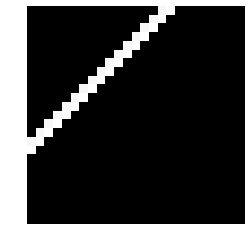

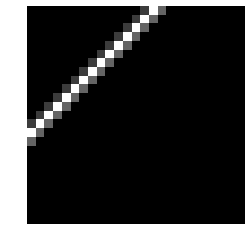

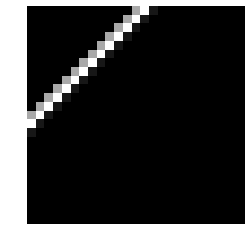

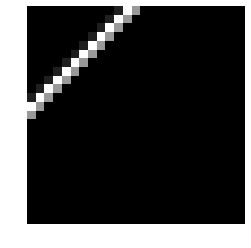

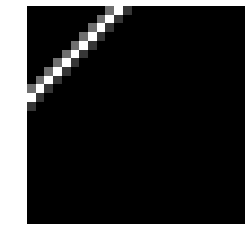

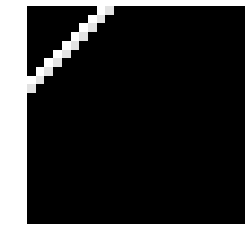

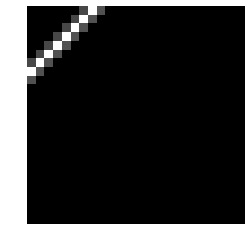

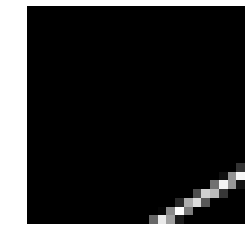

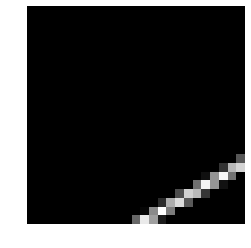

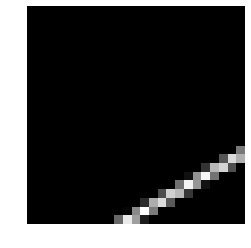

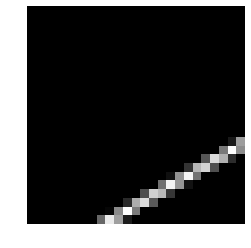

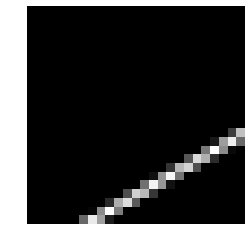

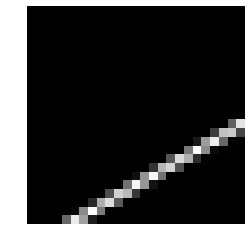

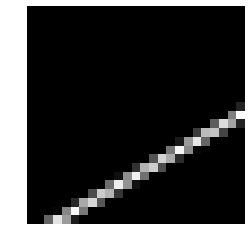

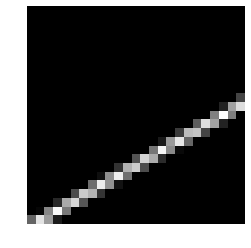

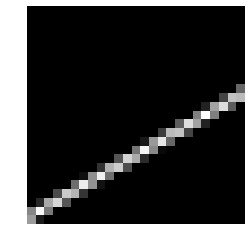

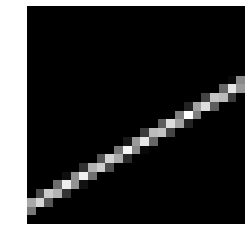

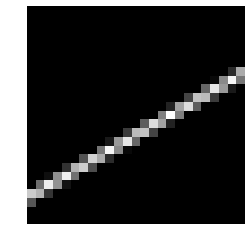

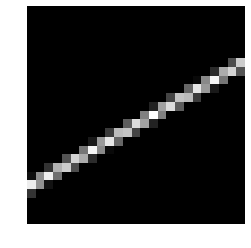

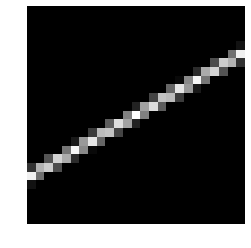

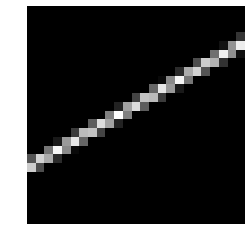

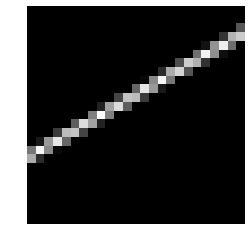

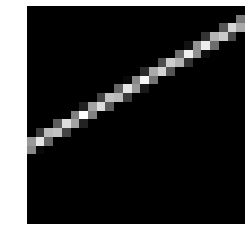

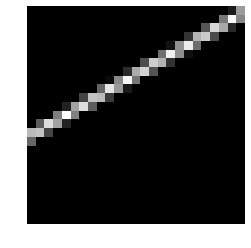

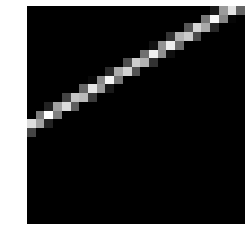

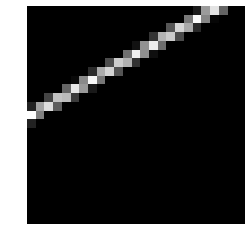

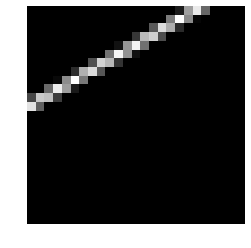

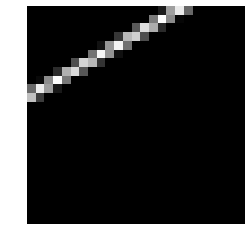

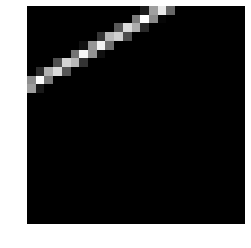

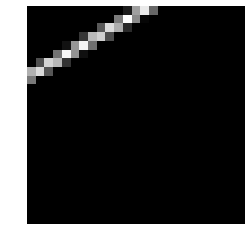

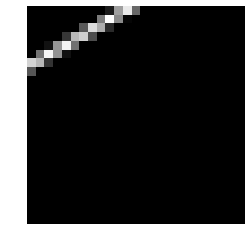

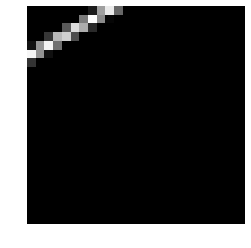

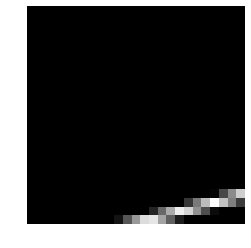

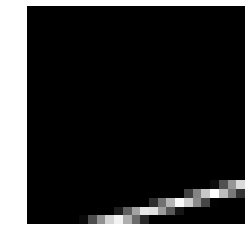

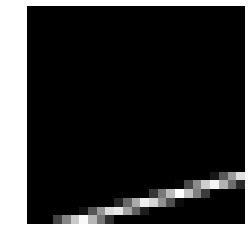

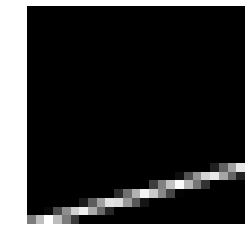

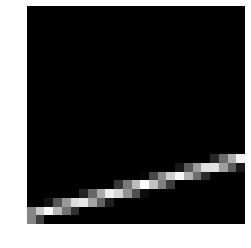

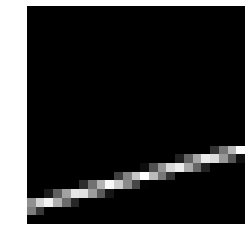

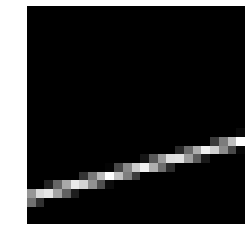

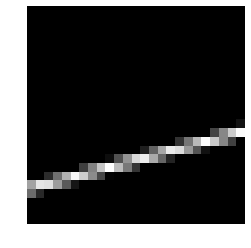

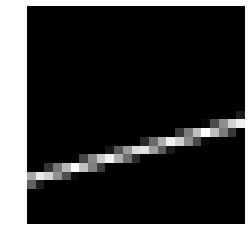

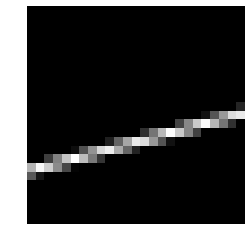

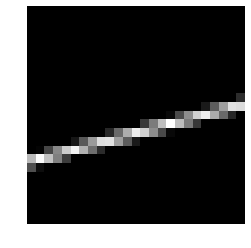

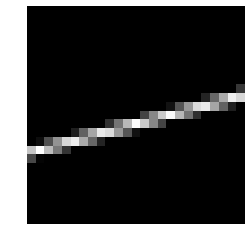

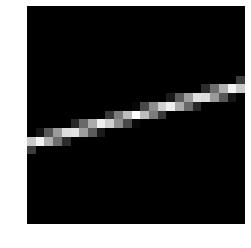

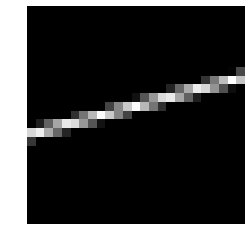

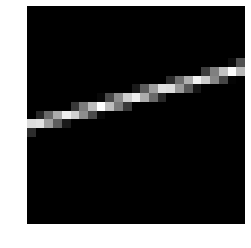

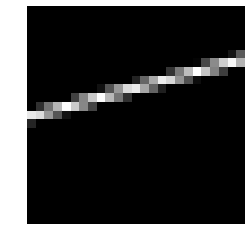

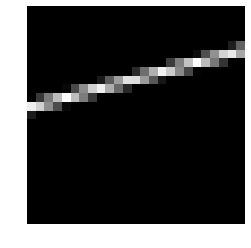

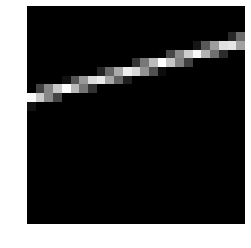

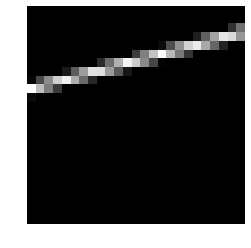

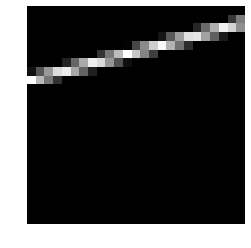

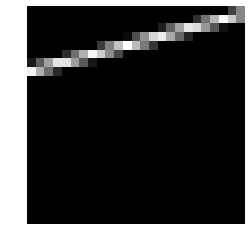

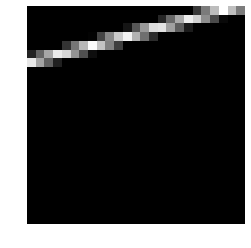

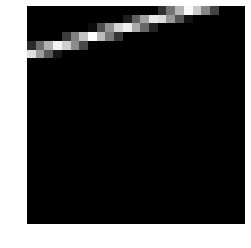

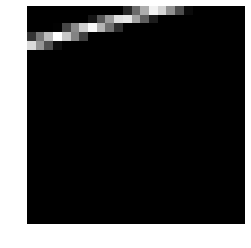

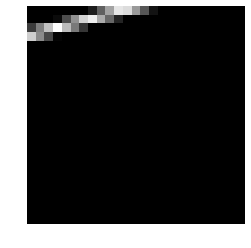

In [16]:
for i in range(proj_operator.shape[0]):
    plt.imshow(np.array(proj_operator.todense())[i].reshape(l,l), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [17]:
# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.1)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

In [18]:
# Reconstruction with L1 (Lasso) penalization
rec_l1, objective_history = lasso_ADMM(np.array(proj_operator.todense()), proj.ravel(), lam=0.05, max_iter=1000)
rec_l1 = rec_l1.reshape(l, l)

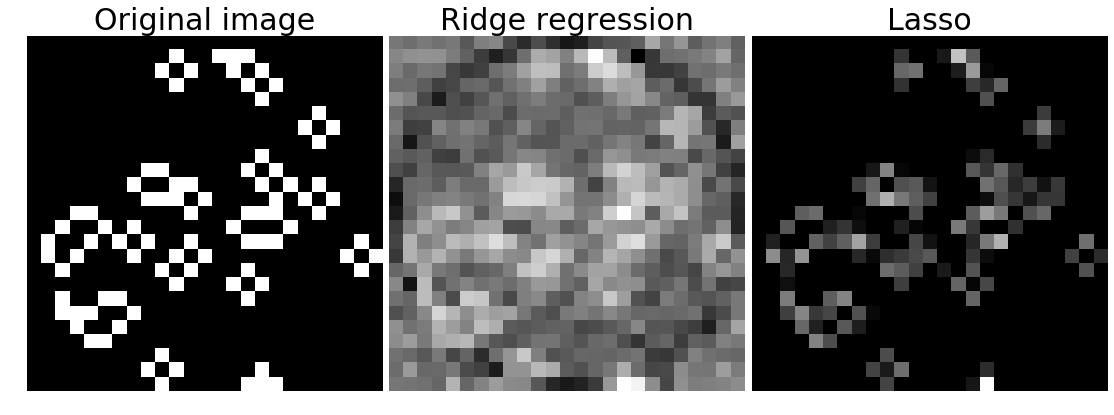

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('Original image', fontsize=30)

plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Ridge regression', fontsize=30)
plt.axis('off')

plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Lasso', fontsize=30)
plt.axis('off')

plt.subplots_adjust(hspace=0.02, wspace=0.02, top=1, bottom=0, left=0, right=1)
plt.show()

## Logistic regression with L1 regularization

For the $\theta$ step, we will need to approximate the optimal $\theta$ using (for example) a gradient descent (see notebook 1 about GD).

In [20]:
n_samples, n_features = 100, 100
sigma = 0.1 # Noise level

# Sparse coefficients: keep only 10 non-zero coefficients
theta_star = np.random.randn(n_features)
ind = np.arange(n_features)
np.random.shuffle(ind)
theta_star[ind[:-10]] = 0.

# Simulate the data
X = np.random.randn(n_samples, n_features)
y = np.sign(X.dot(theta_star) + sigma*np.random.randn(n_samples))

In [21]:
def grad_f(X, theta, rho, u, tau):
    '''Return the gardient of the logistic loss `f` at point `theta`.'''
    n = X.shape[0]
    return (1./n)*(-y/(1 + np.exp(y * X.dot(theta)))).dot(X) + tau * (theta - rho + u)

In [22]:
def optimize_theta(X, theta, rho, u, tau):

    max_iter = 100

    # Step size
    n,p = X.shape
    L = np.linalg.norm((1./n)*X.T.dot(X), ord=2)
    step_size = 1/L
    
    # Random initial point
    theta = np.random.randn(p)

    # Gradient Descent Iterations
    for t in range(max_iter):
        theta = theta - step_size * grad_f(X, theta, rho, u, tau)
    
    return theta

In [23]:
def objective_logistic(theta, X, y, lam):
    '''
        Return the objective for logistic regression with l1 regularization.
    '''
    
    return np.mean(np.log(1.0 + np.exp(-y*X.dot(theta)))) + lam*np.sum(np.abs(theta))

In [24]:
def logistic_ADMM(X, y, lam, max_iter=100, tau=1.):
    '''
        Run the ADMM iterations for the Lasso.
    '''
    n_samples, n_features = X.shape
    rho = np.zeros(n_features)
    u = np.zeros(n_features)
    
    objective_history = []
    
    theta = np.random.randn(n_features)
    for _ in range(max_iter):
        theta = optimize_theta(X, theta, rho, u, tau)
        rho = np.fmax(theta + u - lam/tau, 0) - np.fmax(-lam/tau - theta - u, 0)
        u = u + theta - rho
        objective_history.append(objective_logistic(theta, X, y, lam))

    return theta, objective_history

In [25]:
lam = np.sqrt(2*sigma*np.log(n_features)/n_samples)
theta_hat, objective_history = logistic_ADMM(X, y, lam)

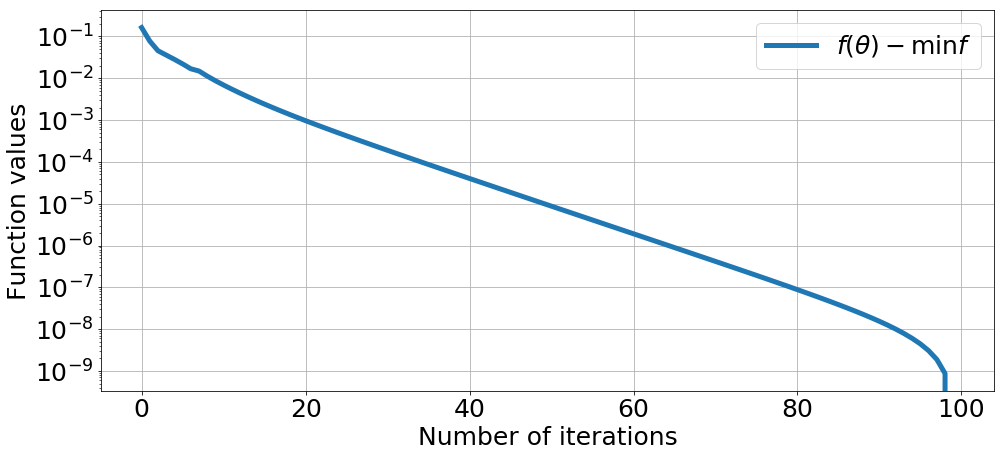

In [26]:
plt.figure(figsize=(16,7))
plt.semilogy(objective_history-np.min(objective_history), lw=5, label='$f(\\theta) - \min{f}$')
plt.ylabel('Function values', fontsize=25)
plt.xlabel('Number of iterations', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()

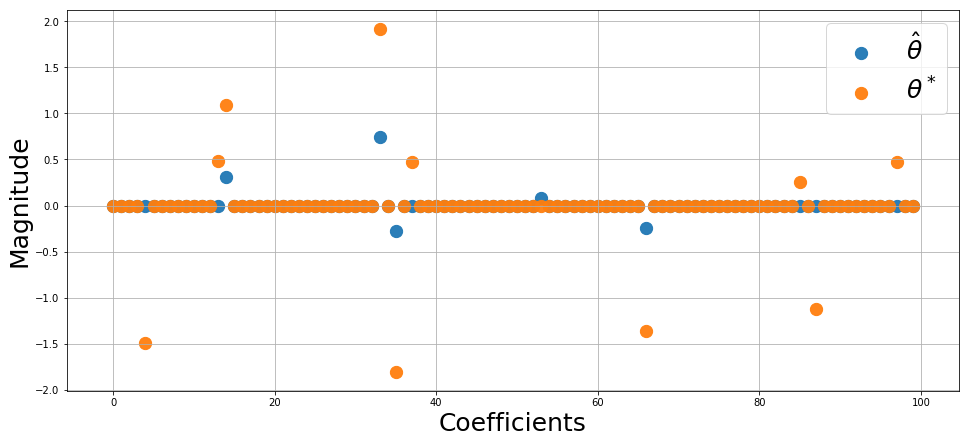

In [27]:
plt.figure(figsize=(16,7))
plt.scatter(range(n_features), theta_hat, alpha=0.95, s=150, label='$\hat\\theta$')
plt.scatter(range(n_features), theta_star, alpha=0.95, s=150, label='$\\theta^*$')
plt.ylabel('Magnitude', fontsize=25)
plt.xlabel('Coefficients', fontsize=25)
plt.legend(fontsize=25)
plt.grid()
plt.show()